In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,647 cases (7 day average) as of Sun 16 May, -43.7 since Sat 15 May
76 hospitalised (7 day average) as of Tue 18 May, +1.6 since Mon 17 May
6 died (7 day average) as of Sun 16 May, +0.0 since Sat 15 May


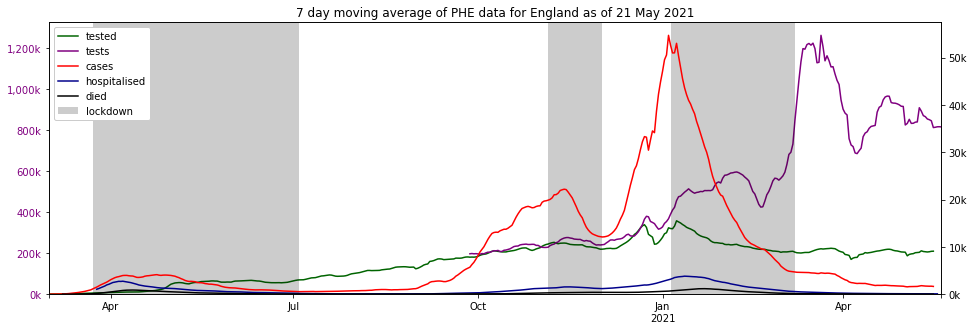

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

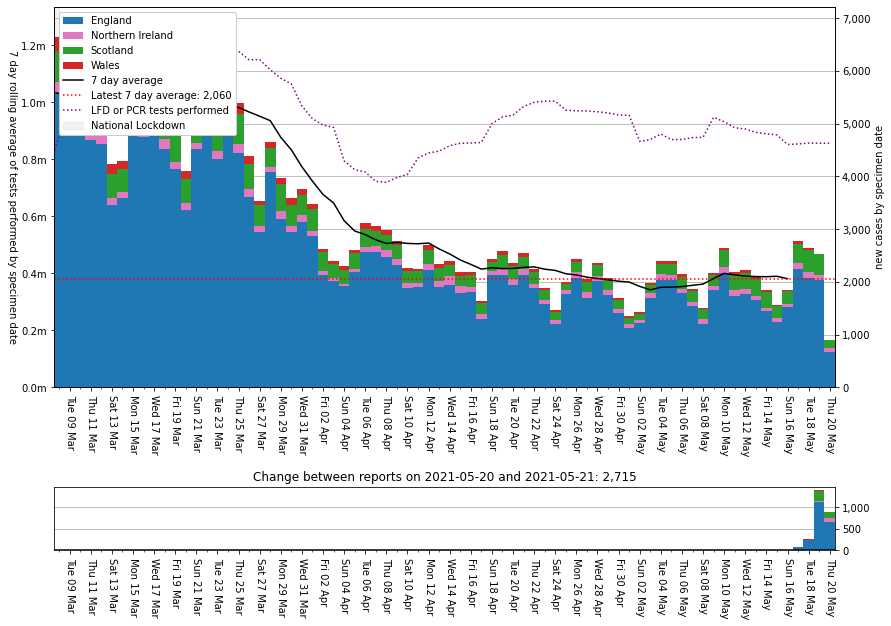

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

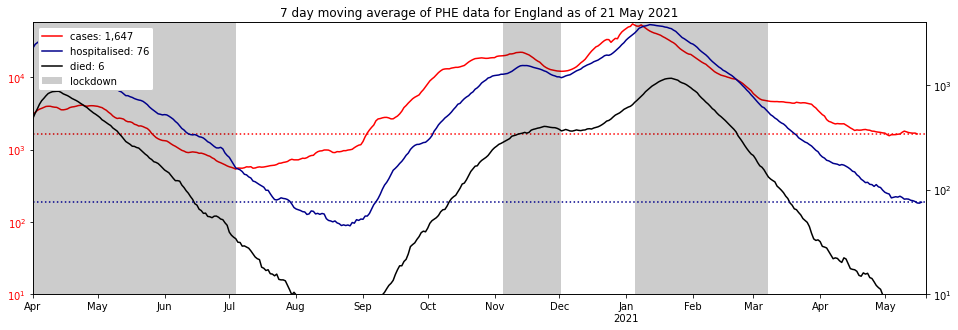

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

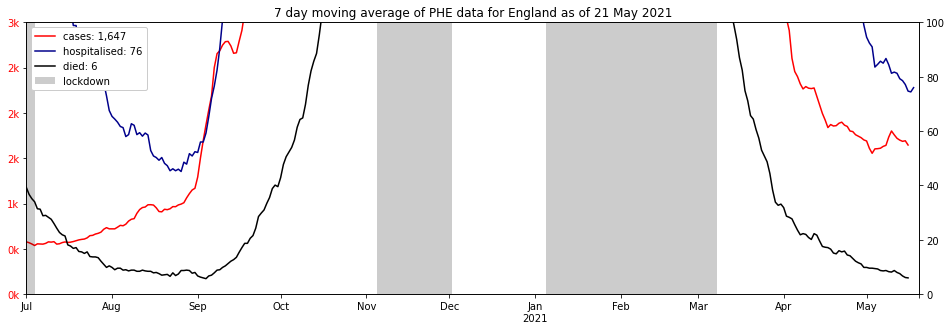

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,20 May 21,"+18,328,096","+31,354,838","+18,328,096","+367,142","+234,818","+367,142"
Northern Ireland,20 May 21,"+592,965","+1,011,836","+592,965","+8,988","+3,247","+8,988"
Scotland,20 May 21,"+1,769,040","+3,082,251","+1,769,040","+26,968","+18,603","+26,968"
Wales,20 May 21,"+969,682","+2,069,689","+969,682","+17,214","+11,583","+17,214"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,18328096.0,31354838.0,13026742.0,56286961,32.561886,23.143445,44.294669
1,Northern Ireland,N92000002,592965.0,1011836.0,418871.0,1893667,31.313056,22.119570,46.567374
2,Scotland,S92000003,1769040.0,3082251.0,1313211.0,5463300,32.380429,24.036956,43.582615
3,Wales,W92000004,969682.0,2069689.0,1100007.0,3152879,30.755446,34.888970,34.355584


'partial: 37,518,614 (56.2%), full: 21,659,783'

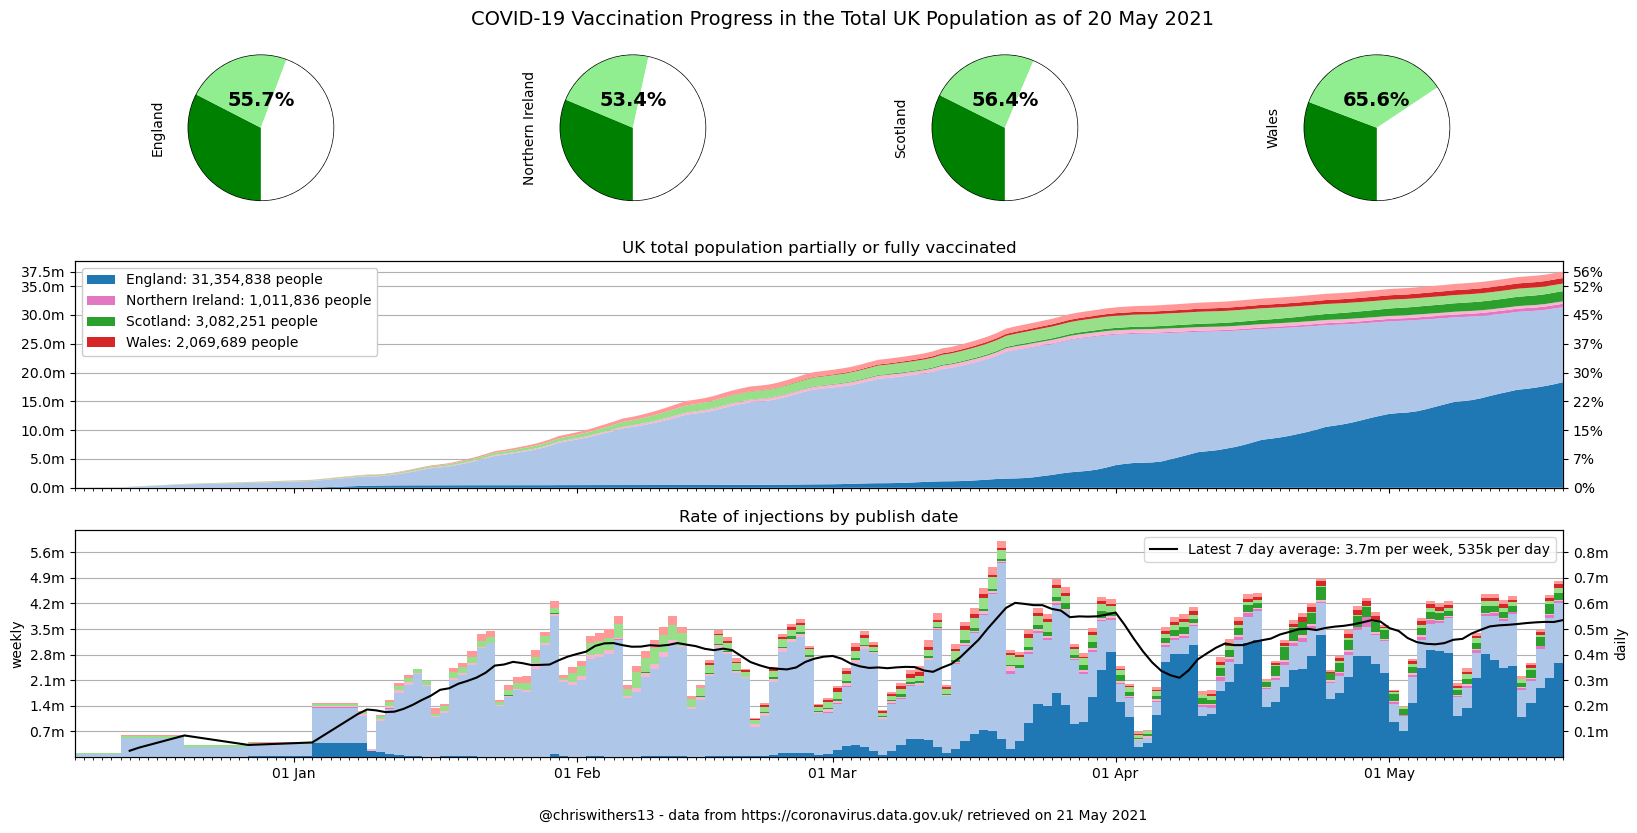

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

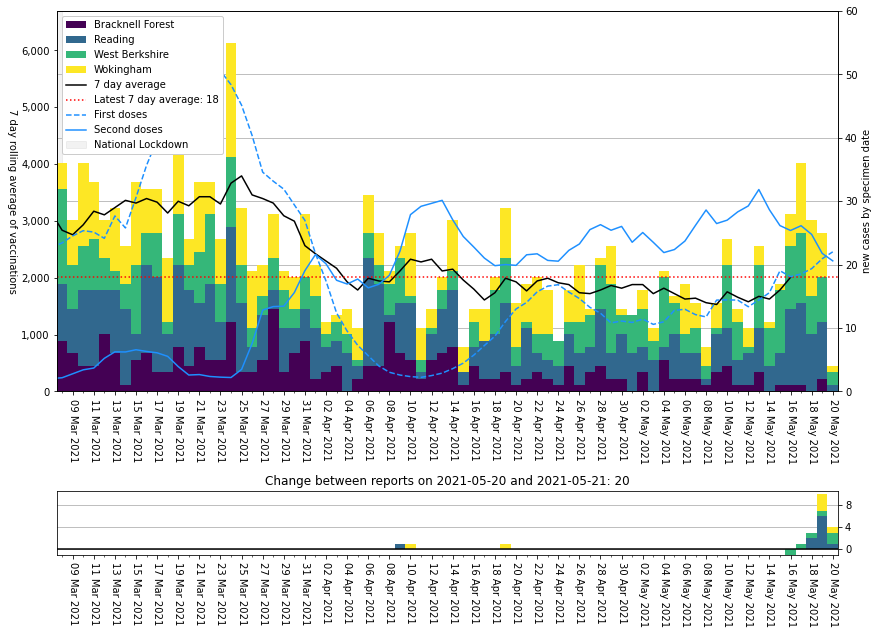

In [22]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60,  lines=daily_vaccinations)

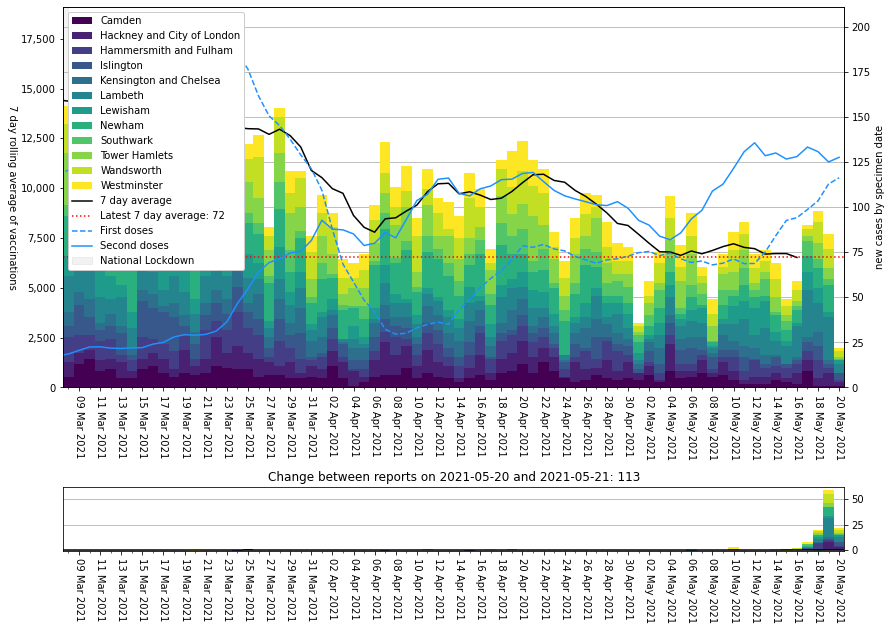

In [25]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=daily_vaccinations)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,385.324291,1108.0,2021-05-20
E06000008,Blackburn with Darwen,234.475203,351.0,2021-05-20
E06000055,Bedford,153.498142,266.0,2021-05-20
S12000049,Glasgow City,118.618903,751.0,2021-05-20
S12000005,Clackmannanshire,116.414435,60.0,2021-05-20
S12000011,East Renfrewshire,107.819533,103.0,2021-05-20
E08000034,Kirklees,89.361441,393.0,2021-05-20
N09000005,Derry City and Strabane,77.337987,117.0,2021-05-20
E07000117,Burnley,58.479532,52.0,2021-05-20


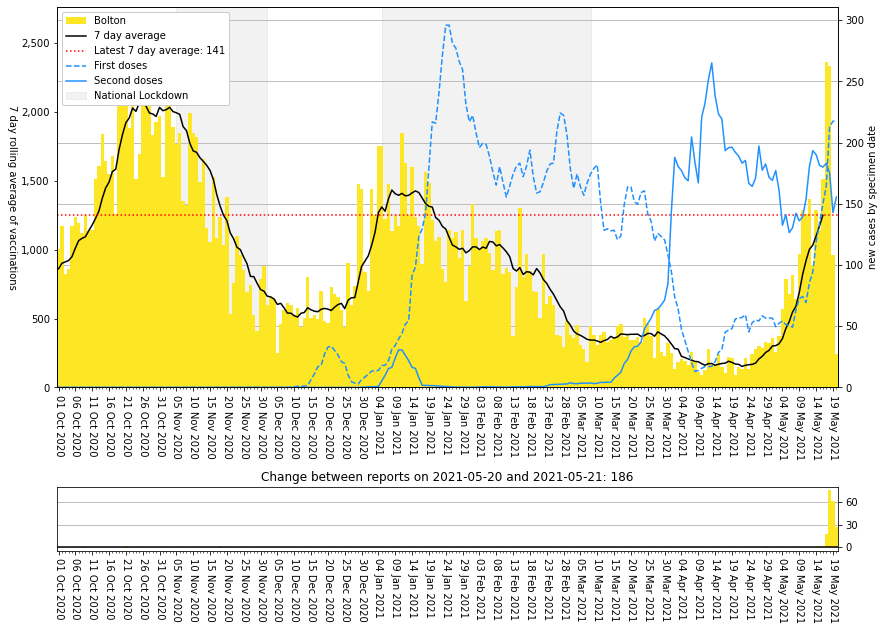

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=daily_vaccinations)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,385.324291,1108.0,2021-05-20
S12000049,Glasgow City,118.618903,751.0,2021-05-20
E08000034,Kirklees,89.361441,393.0,2021-05-20
E06000008,Blackburn with Darwen,234.475203,351.0,2021-05-20
E08000035,Leeds,35.681009,283.0,2021-05-20
E08000003,Manchester,48.294499,267.0,2021-05-20
E06000055,Bedford,153.498142,266.0,2021-05-20
E08000032,Bradford,44.462888,240.0,2021-05-20
E08000025,Birmingham,20.318510,232.0,2021-05-20


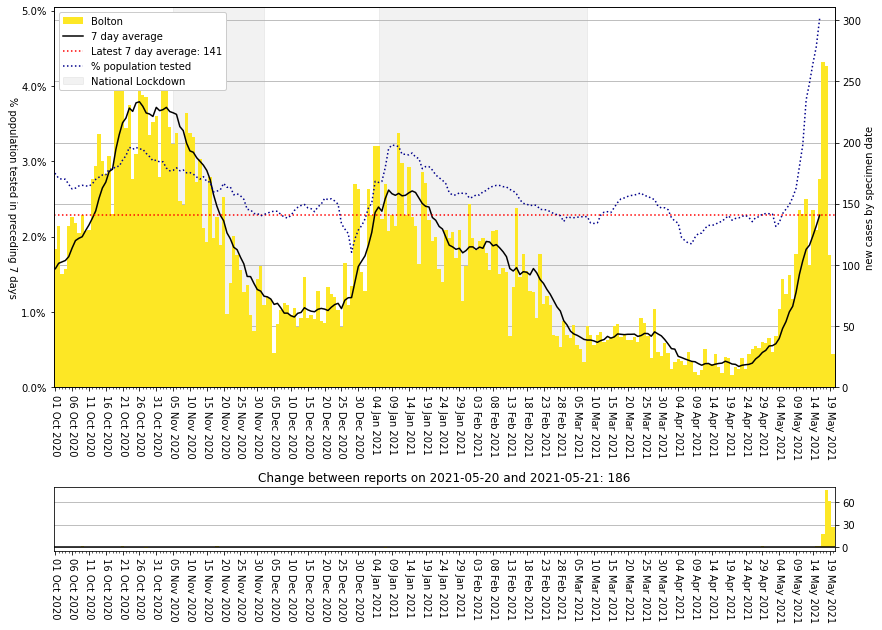

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

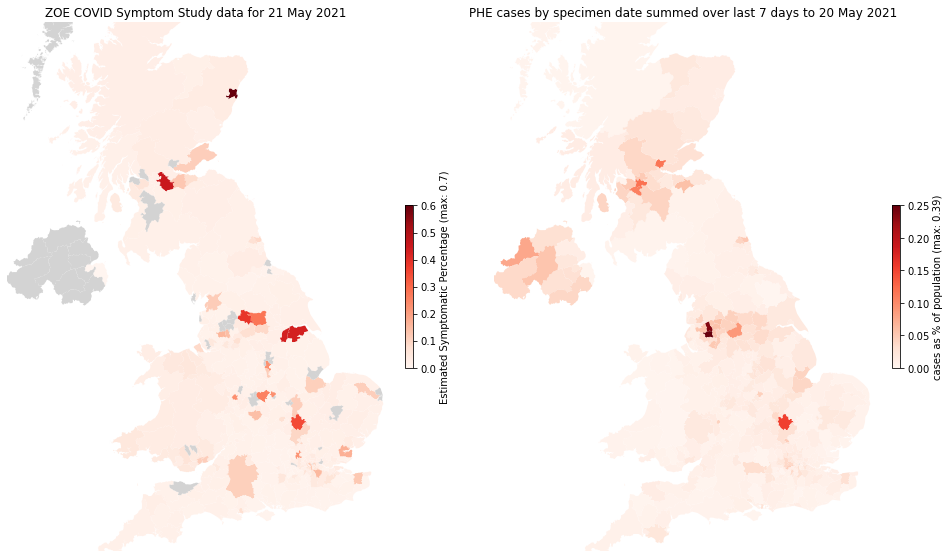

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...